# State Farm Distracted Driver Detection

https://www.kaggle.com/competitions/state-farm-distracted-driver-detection/overview

## Import library

In [2]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# installs
#py -m pip install --upgrade nbformat

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

In [5]:
# The magic below allows us to use tensorflow version 2.x
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

In [6]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
import pandas as pd
np.random.seed(random_seed)

In [7]:
import os
import random
import PIL.Image
from IPython.display import display, Image
import seaborn as sns
import cv2
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras import backend as K
from keras.layers import BatchNormalization, Dense
from keras.metrics import categorical_crossentropy
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input



In [8]:
## Check if system is using GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8377495331600228334
xla_global_id: -1
]


# Scratch CNN with Leakage

## Data Preprocessing

### Loading Data

In [10]:
abspath_curr = os.getcwd()
driver_imgs_list = pd.read_csv('./driver_imgs_list.csv',header=0)

In [11]:
driver_imgs_list.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [12]:
train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    directory_path = os.path.join(abspath_curr, "imgs", "train", "c" + str(i))
    files = os.listdir(directory_path)
    for file_name in files:
        img_name = os.path.join(directory_path, file_name)
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        train_image.append([img,label])
        image_label.append(i)  

now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [13]:
# Get the number of classes
n_classes = 10

### Data Analysis

Creating json for the classes in target

In [14]:
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

class_def = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5': 'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

Displaying sample image

Train image

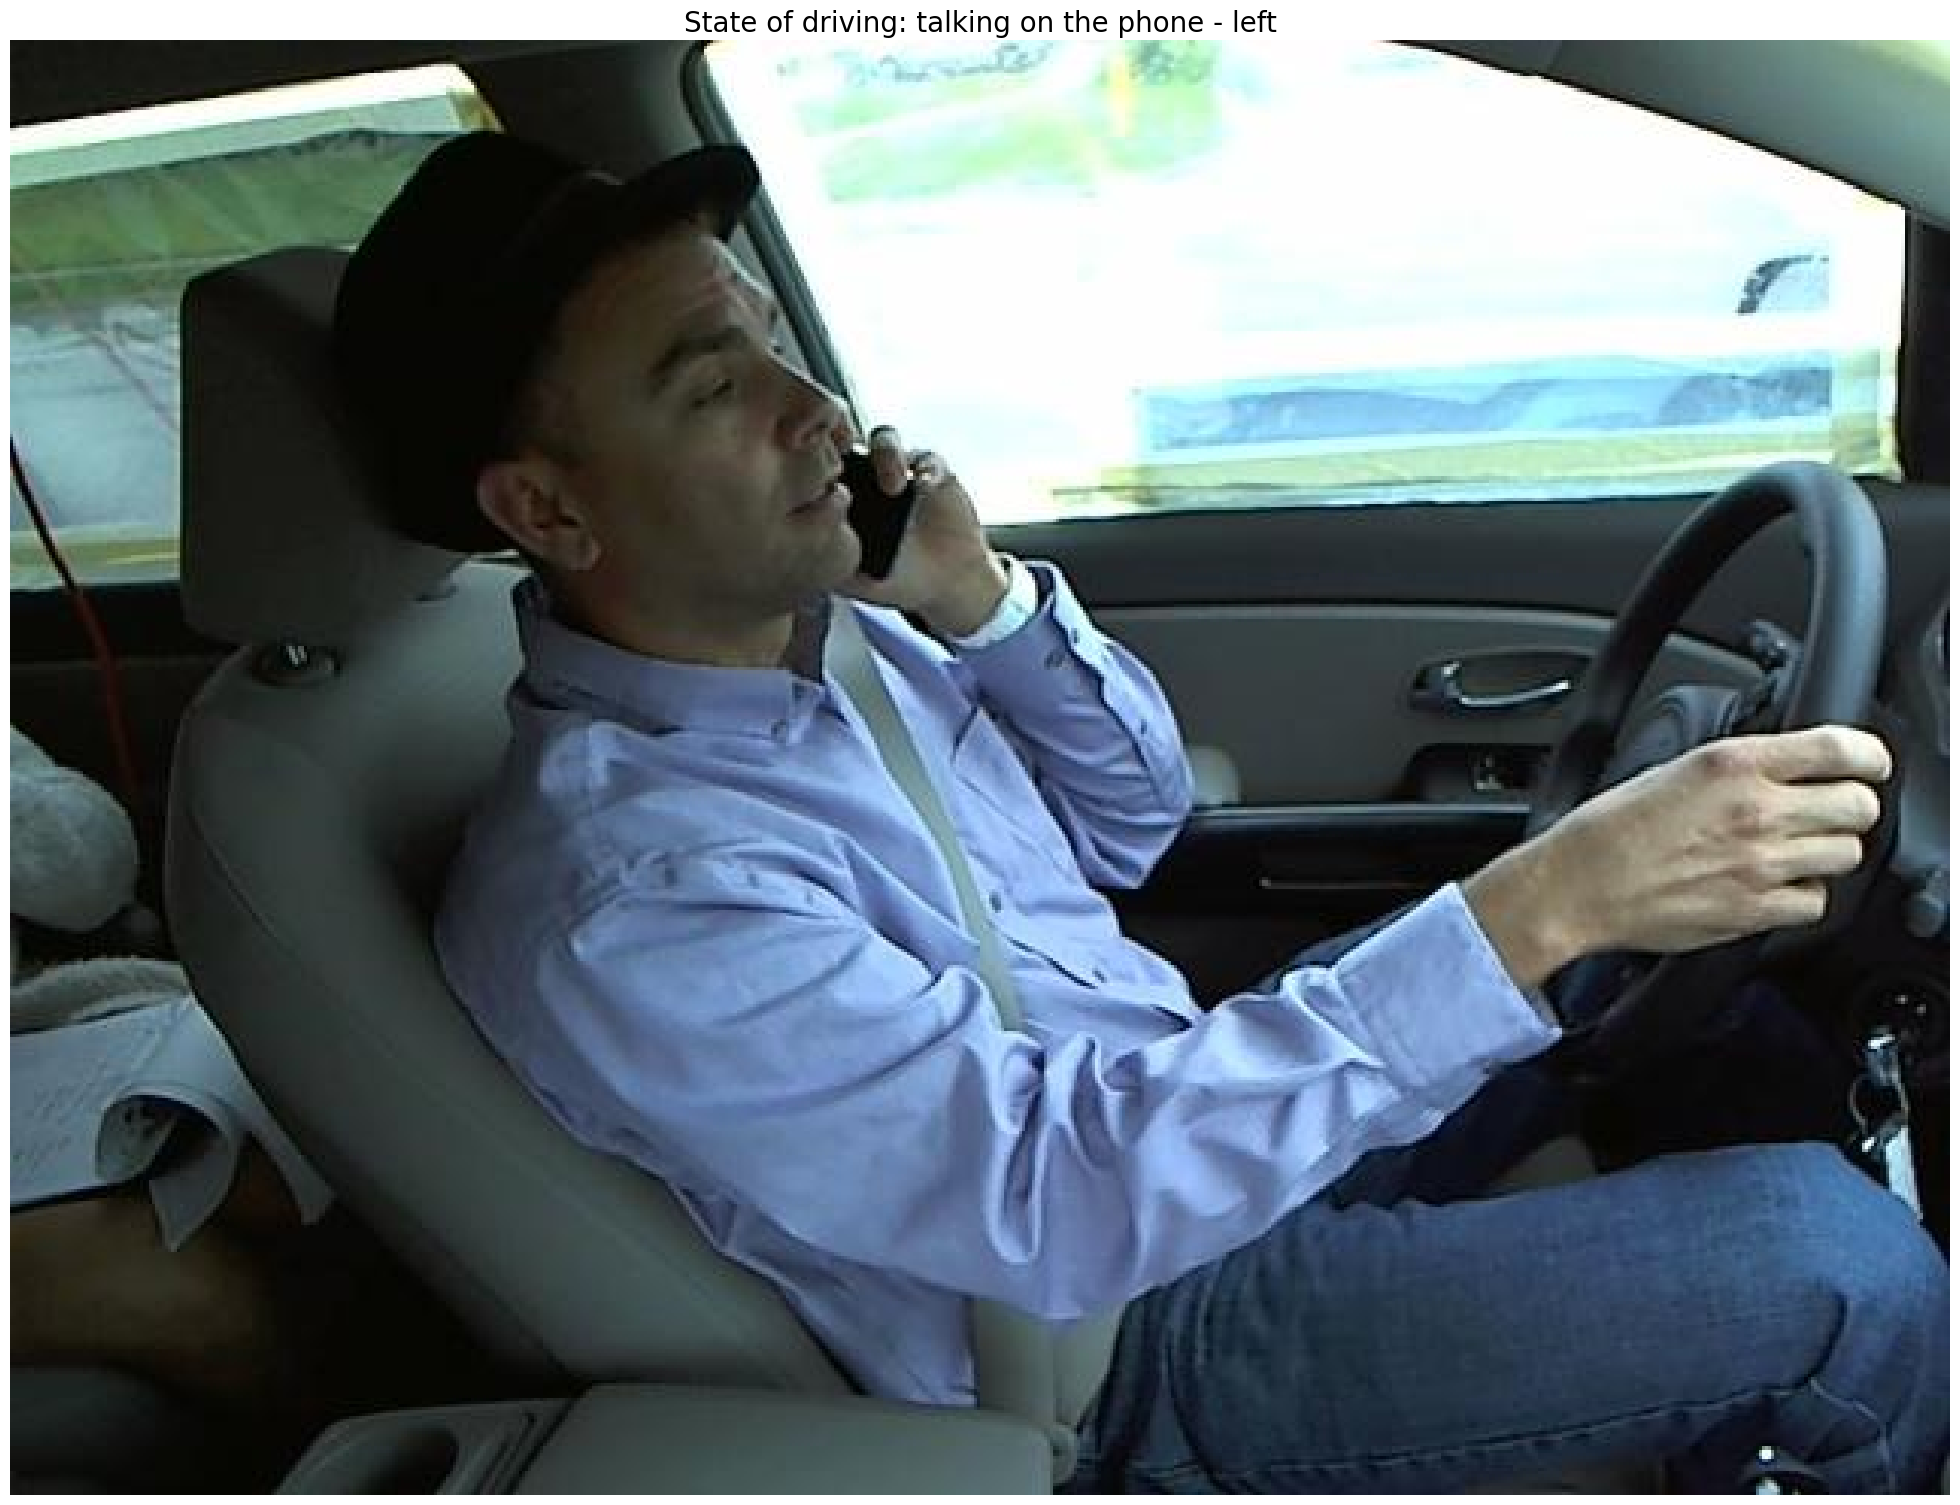

In [17]:
from PIL import Image

fig = plt.figure(figsize=(20, 18))
train_imgs = os.path.join(abspath_curr, "imgs", "train")
pic_idx = random.randint(0, driver_imgs_list.shape[0])
im = Image.open(os.path.join(train_imgs, 
                    str(driver_imgs_list.loc[pic_idx, 'classname']) +'/' 
                    +str(driver_imgs_list.loc[pic_idx, 'img' ])))
plt.imshow(im)
plt.title('State of driving: ' + class_def[(driver_imgs_list.loc[pic_idx, 'classname'])])
plt.axis('off')
plt.tight_layout()
plt.show()

Test image

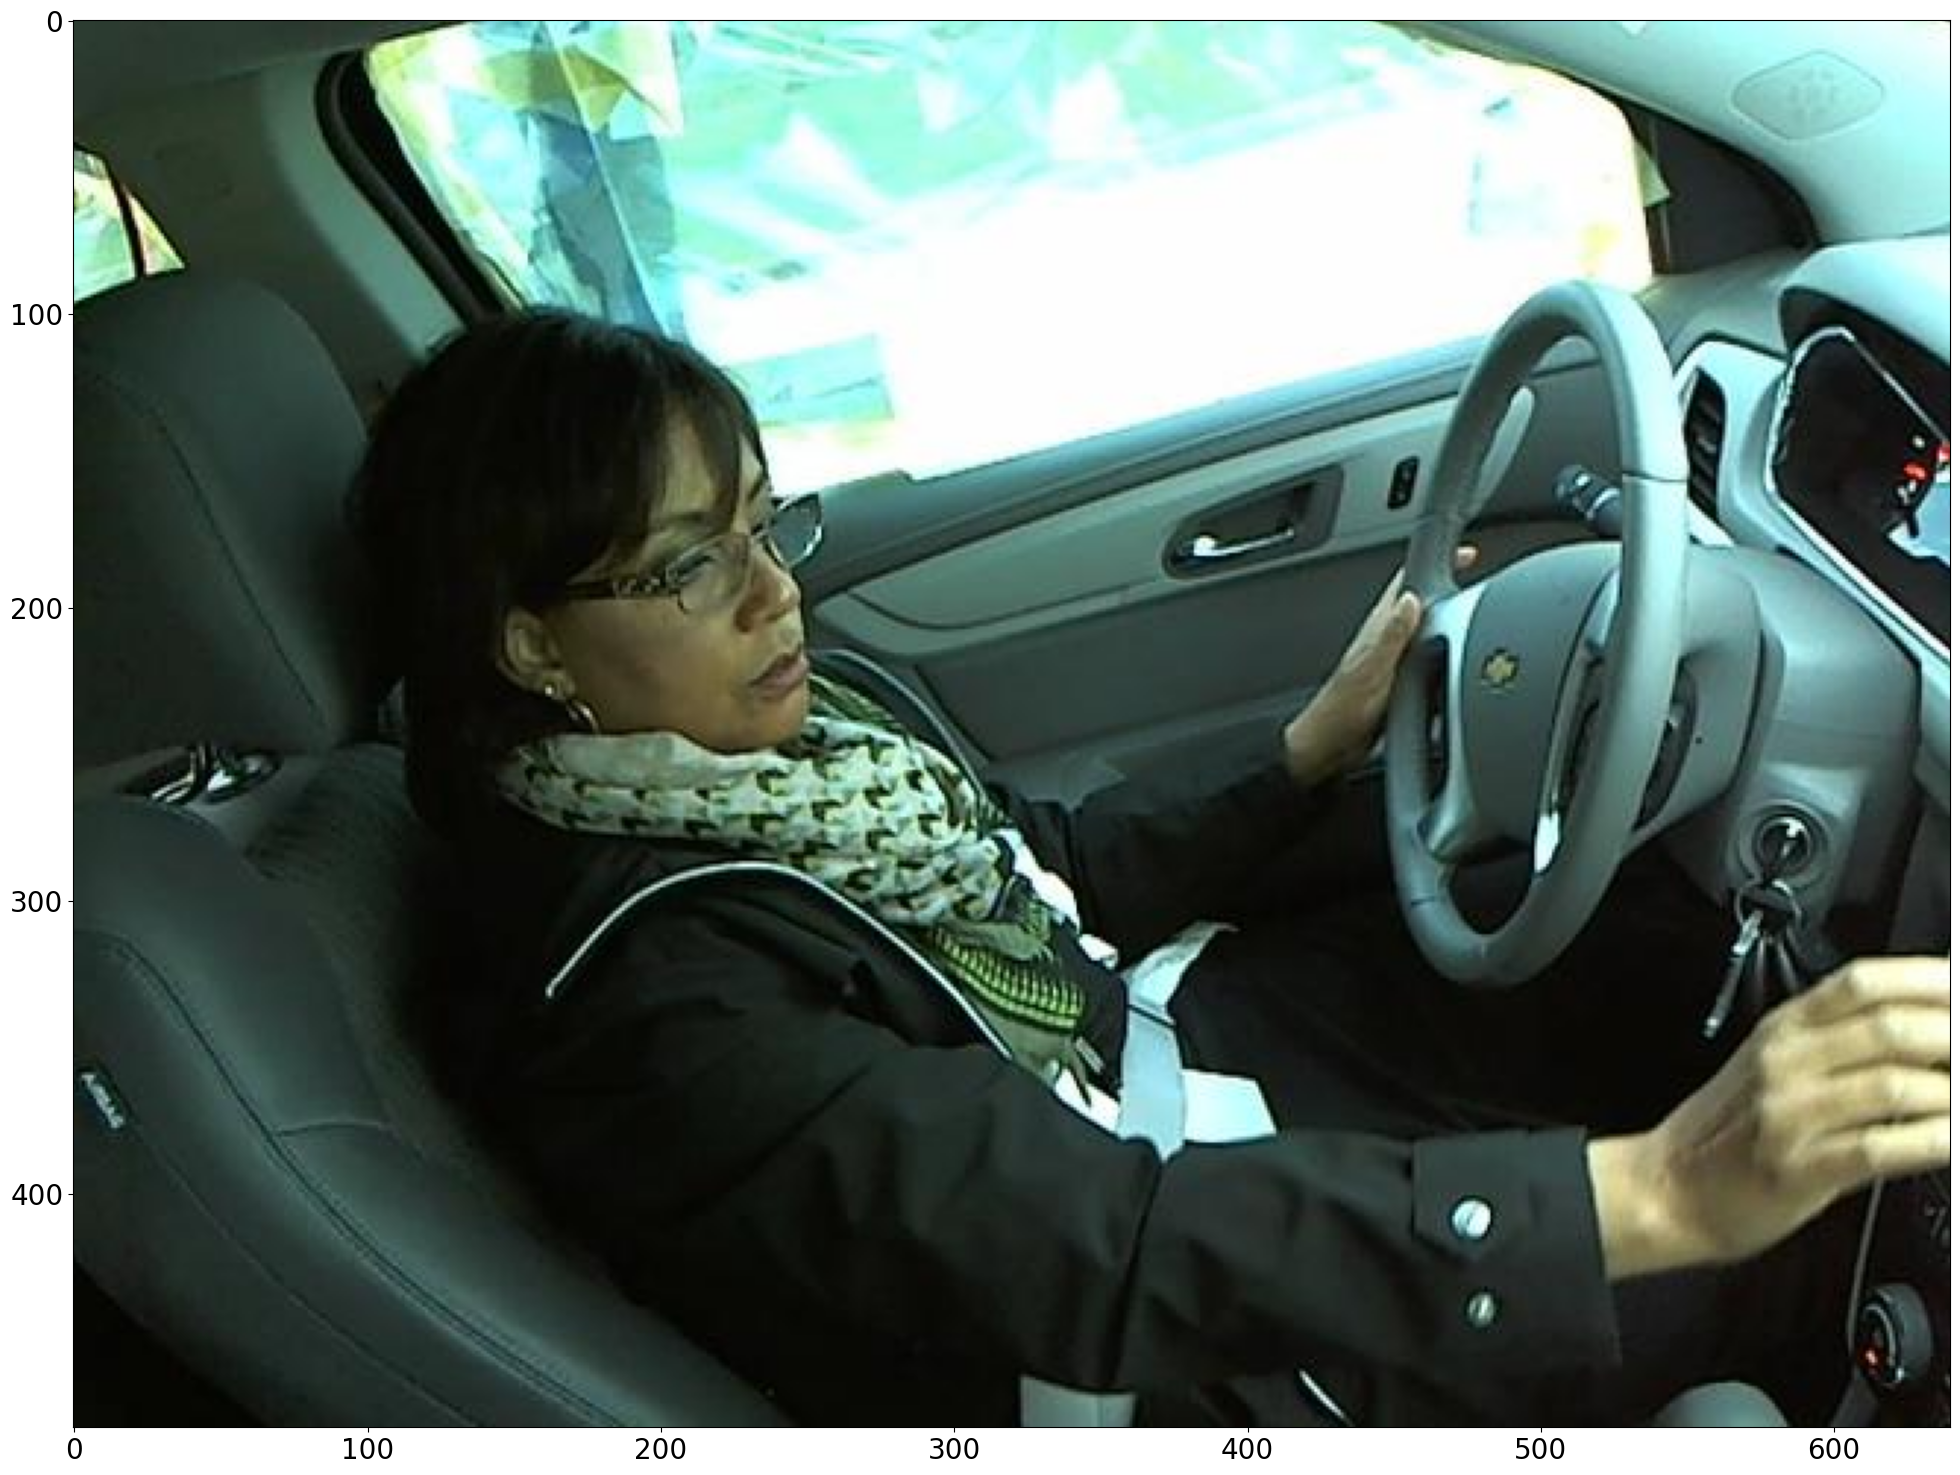

In [18]:
fig = plt.figure(figsize=(20, 18))
test_imgs = os.path.join(abspath_curr, "imgs", "test")
im = Image.open(os.path.join(test_imgs, 'img_1.jpg'))
plt.imshow(im)
plt.tight_layout()
plt.show()

In [19]:
im = Image.open("./imgs/train/c7/img_100702.jpg")
w, h = im.size
print(w, h)

640 480


Size of the image = 640, 480

Total number of training data : 22424


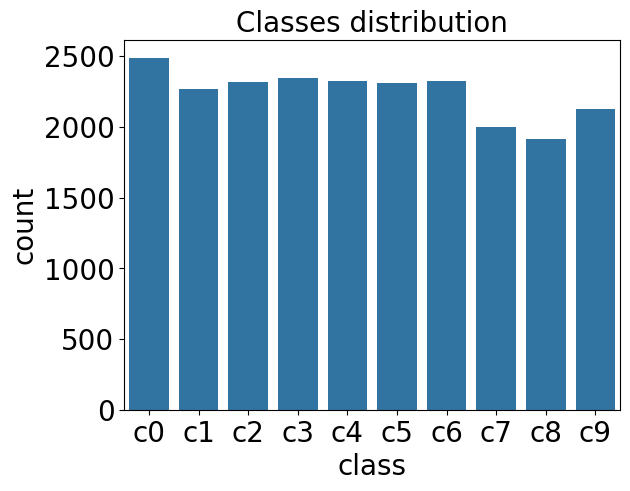

In [20]:

d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(train_imgs,c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
ax = sns.countplot(data=df,x="class")
ax.set(title="Classes distribution")
print("Total number of training data :",len(df))

In [21]:
## Randomly shuffling the images
random.shuffle(train_image)

In [22]:
## Splitting the image and label to two different lists

X = []
Y = []
for features,labels in train_image:
    X.append(features)
    Y.append(labels)

print (len(X), len(Y))

22424 22424


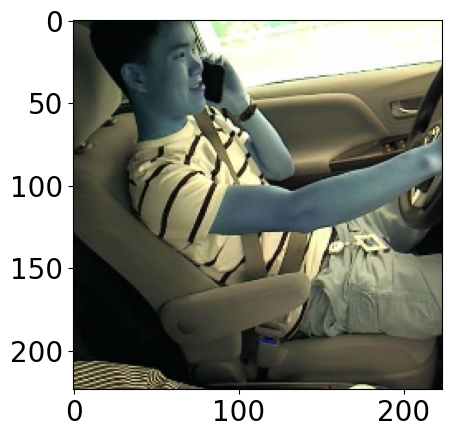

4


In [23]:
plt.imshow(X[5])
plt.show()
print(Y[5])

### Encoding target and resize image

In [24]:
## Converting images to nparray. Encoding the Y
X = np.array(X).reshape(-1,224,224,3)
Y = to_categorical(Y)

print (X.shape)

(22424, 224, 224, 3)


The images are resized to a square images i.e. 224 x 224 pixels.

### Splitting training and validation

Splitting training 80% and validation 20%

In [25]:
## Designing the Layers
X_train, X_val, y_train, y_val = train_test_split(X, Y, random_state=42, test_size=0.2)

Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.

## Training

### Creating the directory for the model

In [26]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/model/')
if not os.path.exists(directory):
    os.makedirs(directory)

### Building the architecture of the model

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(224,224,3),padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    51,380,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,512,970 (196.51 MB)

 Trainable params: 51,512,394 (196.50 MB)

 Non-trainable params: 576 (2.25 KB)

### Compiling the model

In [28]:
# Compile the model
sgd = SGD(learning_rate=0.001)
model.compile(optimizer= sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [29]:
# Train, evaluate and save the best model
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val))

Epoch 1/3
561/561 ━━━━━━━━━━━━━━━━━━━━ 1468s 3s/step - accuracy: 0.7861 - loss: 0.7510 - val_accuracy: 0.9911 - val_loss: 0.0438
Epoch 2/3
561/561 ━━━━━━━━━━━━━━━━━━━━ 1320s 2s/step - accuracy: 0.9998 - loss: 0.0075 - val_accuracy: 0.9938 - val_loss: 0.0234
Epoch 3/3
561/561 ━━━━━━━━━━━━━━━━━━━━ 1483s 3s/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9938 - val_loss: 0.0219


## Model Analysis

### Plotting the learning curve

#### Creating the directory for the figure

In [31]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

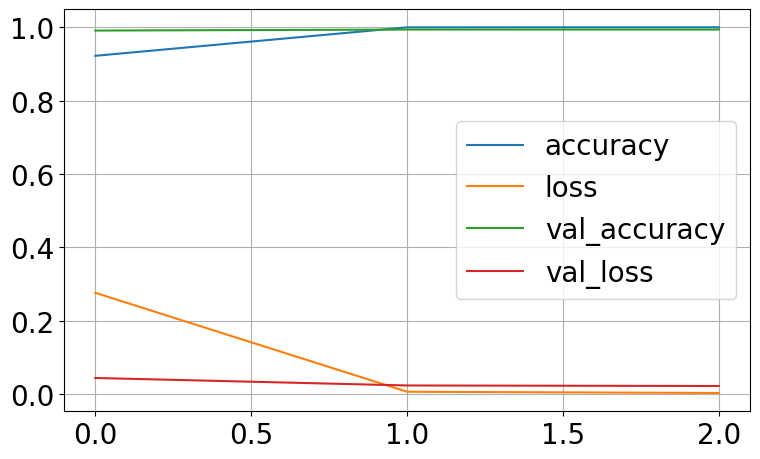

In [32]:

# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/result/figure/learning_curve_CNN_Scratch_leakage.pdf')
plt.show()

In [33]:
y_pred = model.predict(X_val)
y_pred = [np.argmax(ele) for ele in y_pred]
y_pred = np.array(y_pred)

# Calculate the confusion matrix
y_true = [np.argmax(ele) for ele in y_val]
y_true =  np.array(y_true)

conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

141/141 ━━━━━━━━━━━━━━━━━━━━ 55s 388ms/step
Confusion Matrix:
[[511   0   0   0   0   0   1   0   0   0]
 [  1 450   0   0   0   0   0   0   0   0]
 [  1   0 474   0   0   0   1   0   0   0]
 [  0   0   0 460   1   0   0   0   0   0]
 [  0   0   0   1 464   0   0   0   1   0]
 [  1   0   0   0   1 455   0   0   0   1]
 [  0   0   0   0   0   0 429   1   0   0]
 [  0   0   0   1   0   0   2 412   0   1]
 [  0   0   0   0   0   0   0   2 384   3]
 [  1   1   0   0   0   0   0   0   6 418]]


<Axes: >

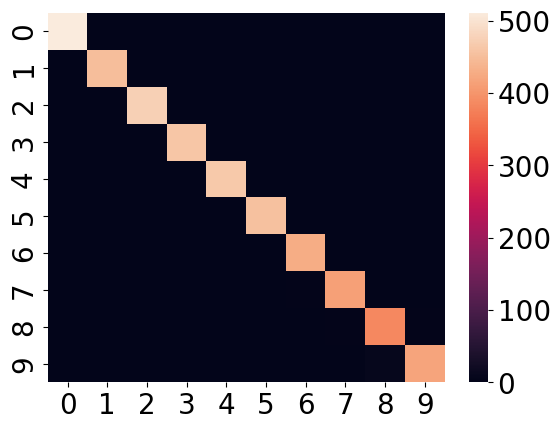

In [34]:
sns.heatmap(conf_matrix)

# Scratch CNN without Leakage

## Data Preprocessing

### Loading Data

In [37]:
abspath_curr = os.getcwd()
driver_imgs_list = pd.read_csv('./driver_imgs_list.csv',header=0)

In [38]:
driver_imgs_list.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [40]:
train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    directory_path = os.path.join(abspath_curr, "imgs", "train", "c" + str(i))
    files = os.listdir(directory_path)
    for file_name in files:
        img_name = os.path.join(directory_path, file_name)
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_imgs_list[driver_imgs_list['img'] == file_name]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)  

now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [41]:
# Get the number of classes
n_classes = 10

### Data Analysis

Creating json for the classes in target

In [42]:
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

class_def = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5': 'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

Displaying sample image

Train image

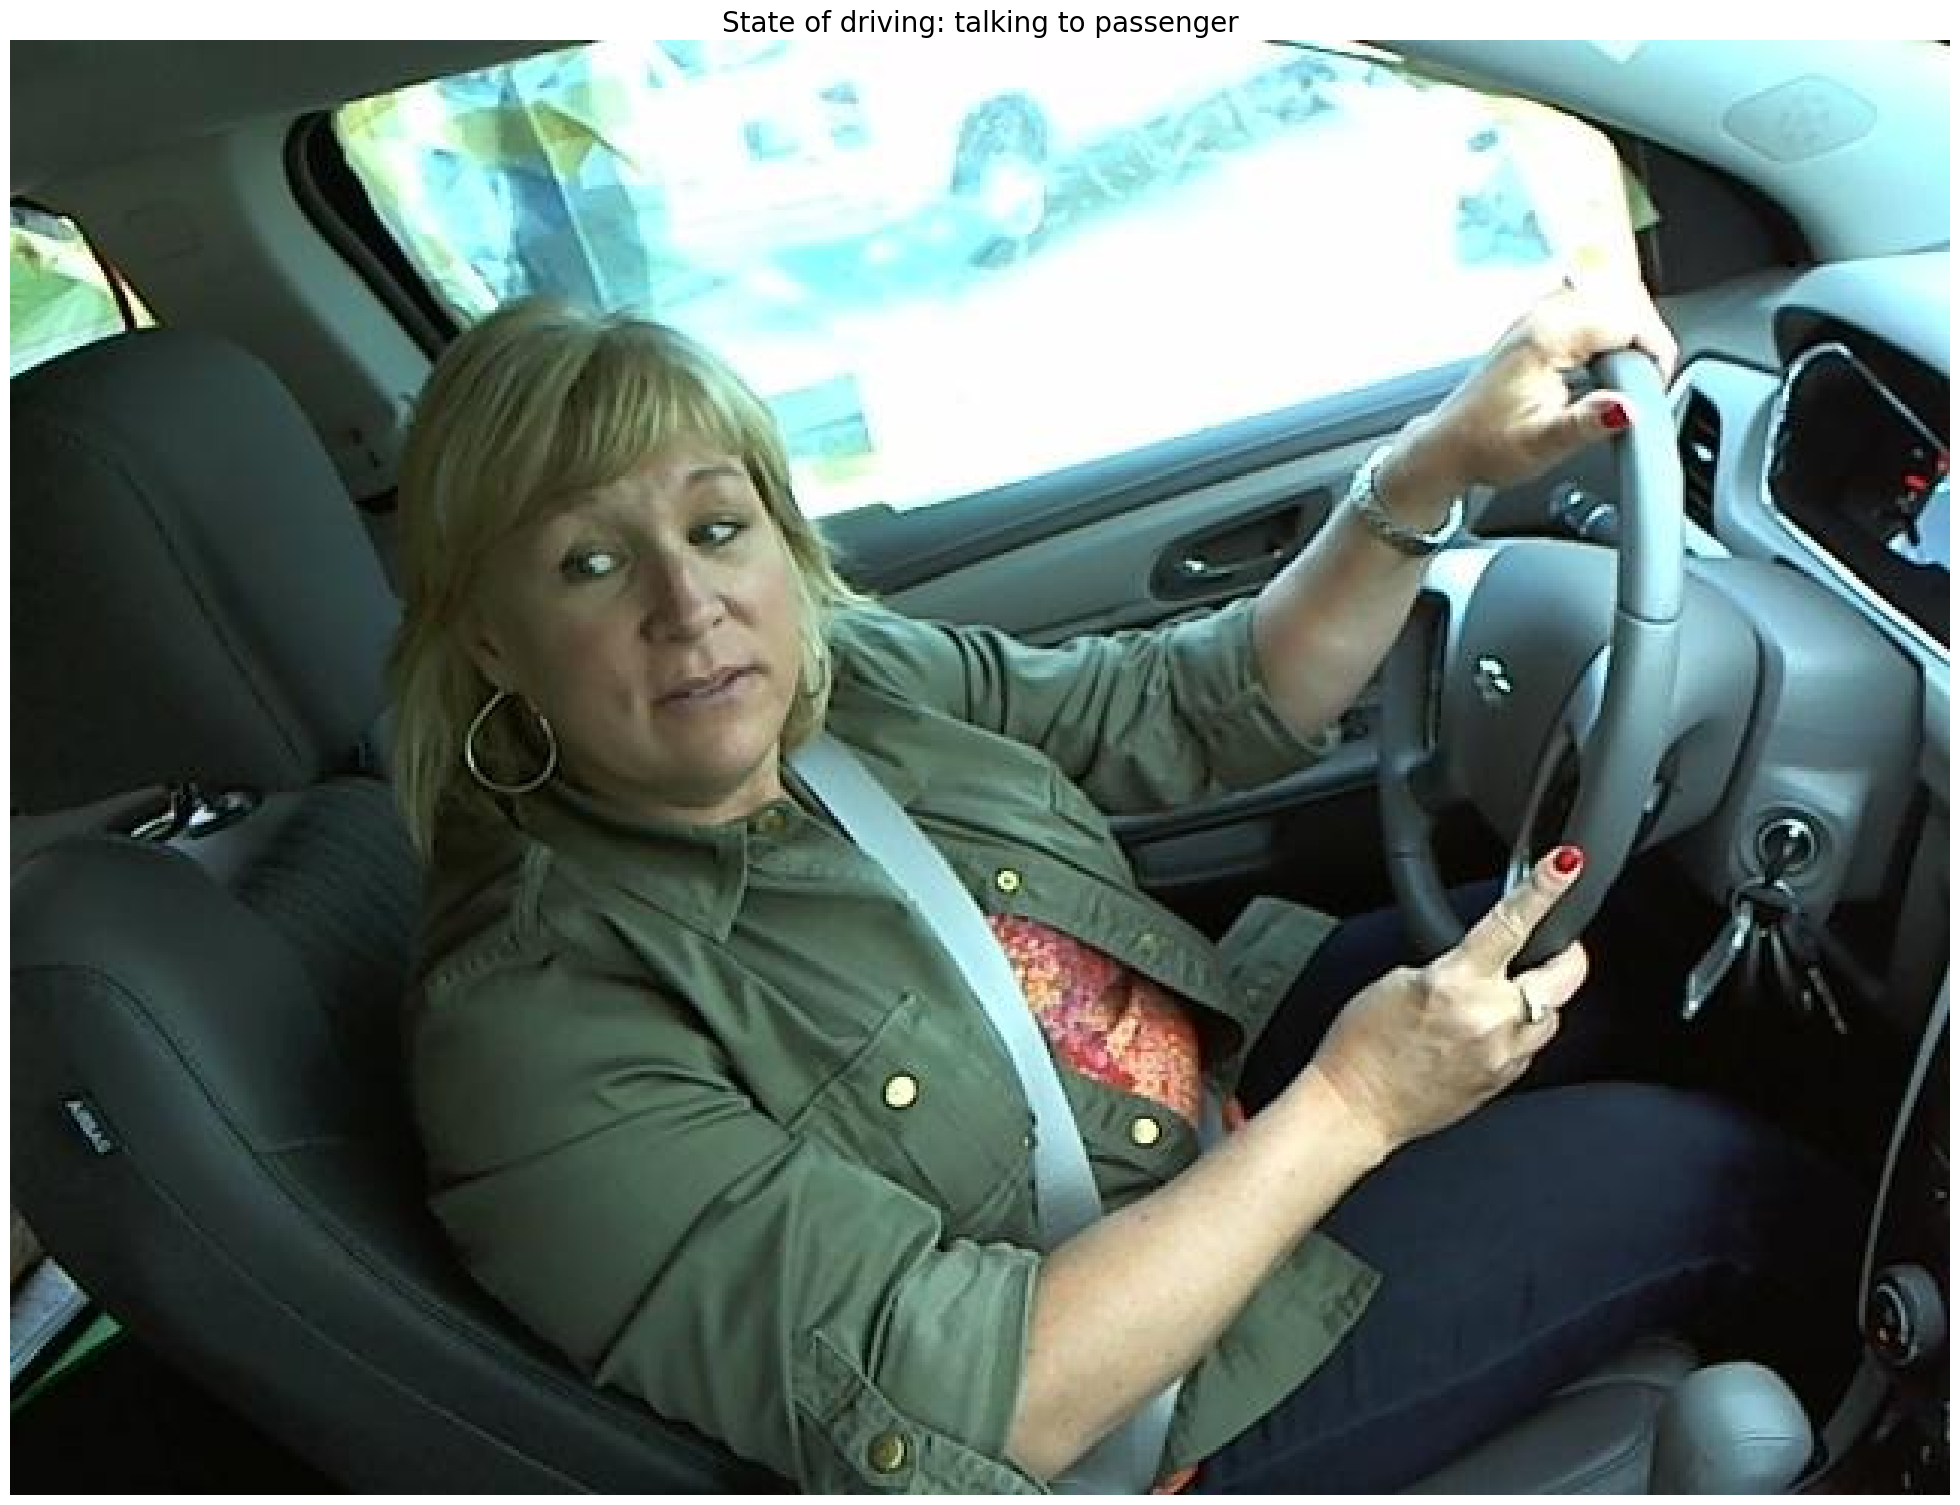

In [43]:

fig = plt.figure(figsize=(20, 18))
train_imgs = os.path.join(abspath_curr, "imgs", "train")
pic_idx = random.randint(0, driver_imgs_list.shape[0])
im = Image.open(os.path.join(train_imgs, 
                    str(driver_imgs_list.loc[pic_idx, 'classname']) +'/' 
                    +str(driver_imgs_list.loc[pic_idx, 'img' ])))
plt.imshow(im)
plt.title('State of driving: ' + class_def[(driver_imgs_list.loc[pic_idx, 'classname'])])
plt.axis('off')
plt.tight_layout()
plt.show()

Test image

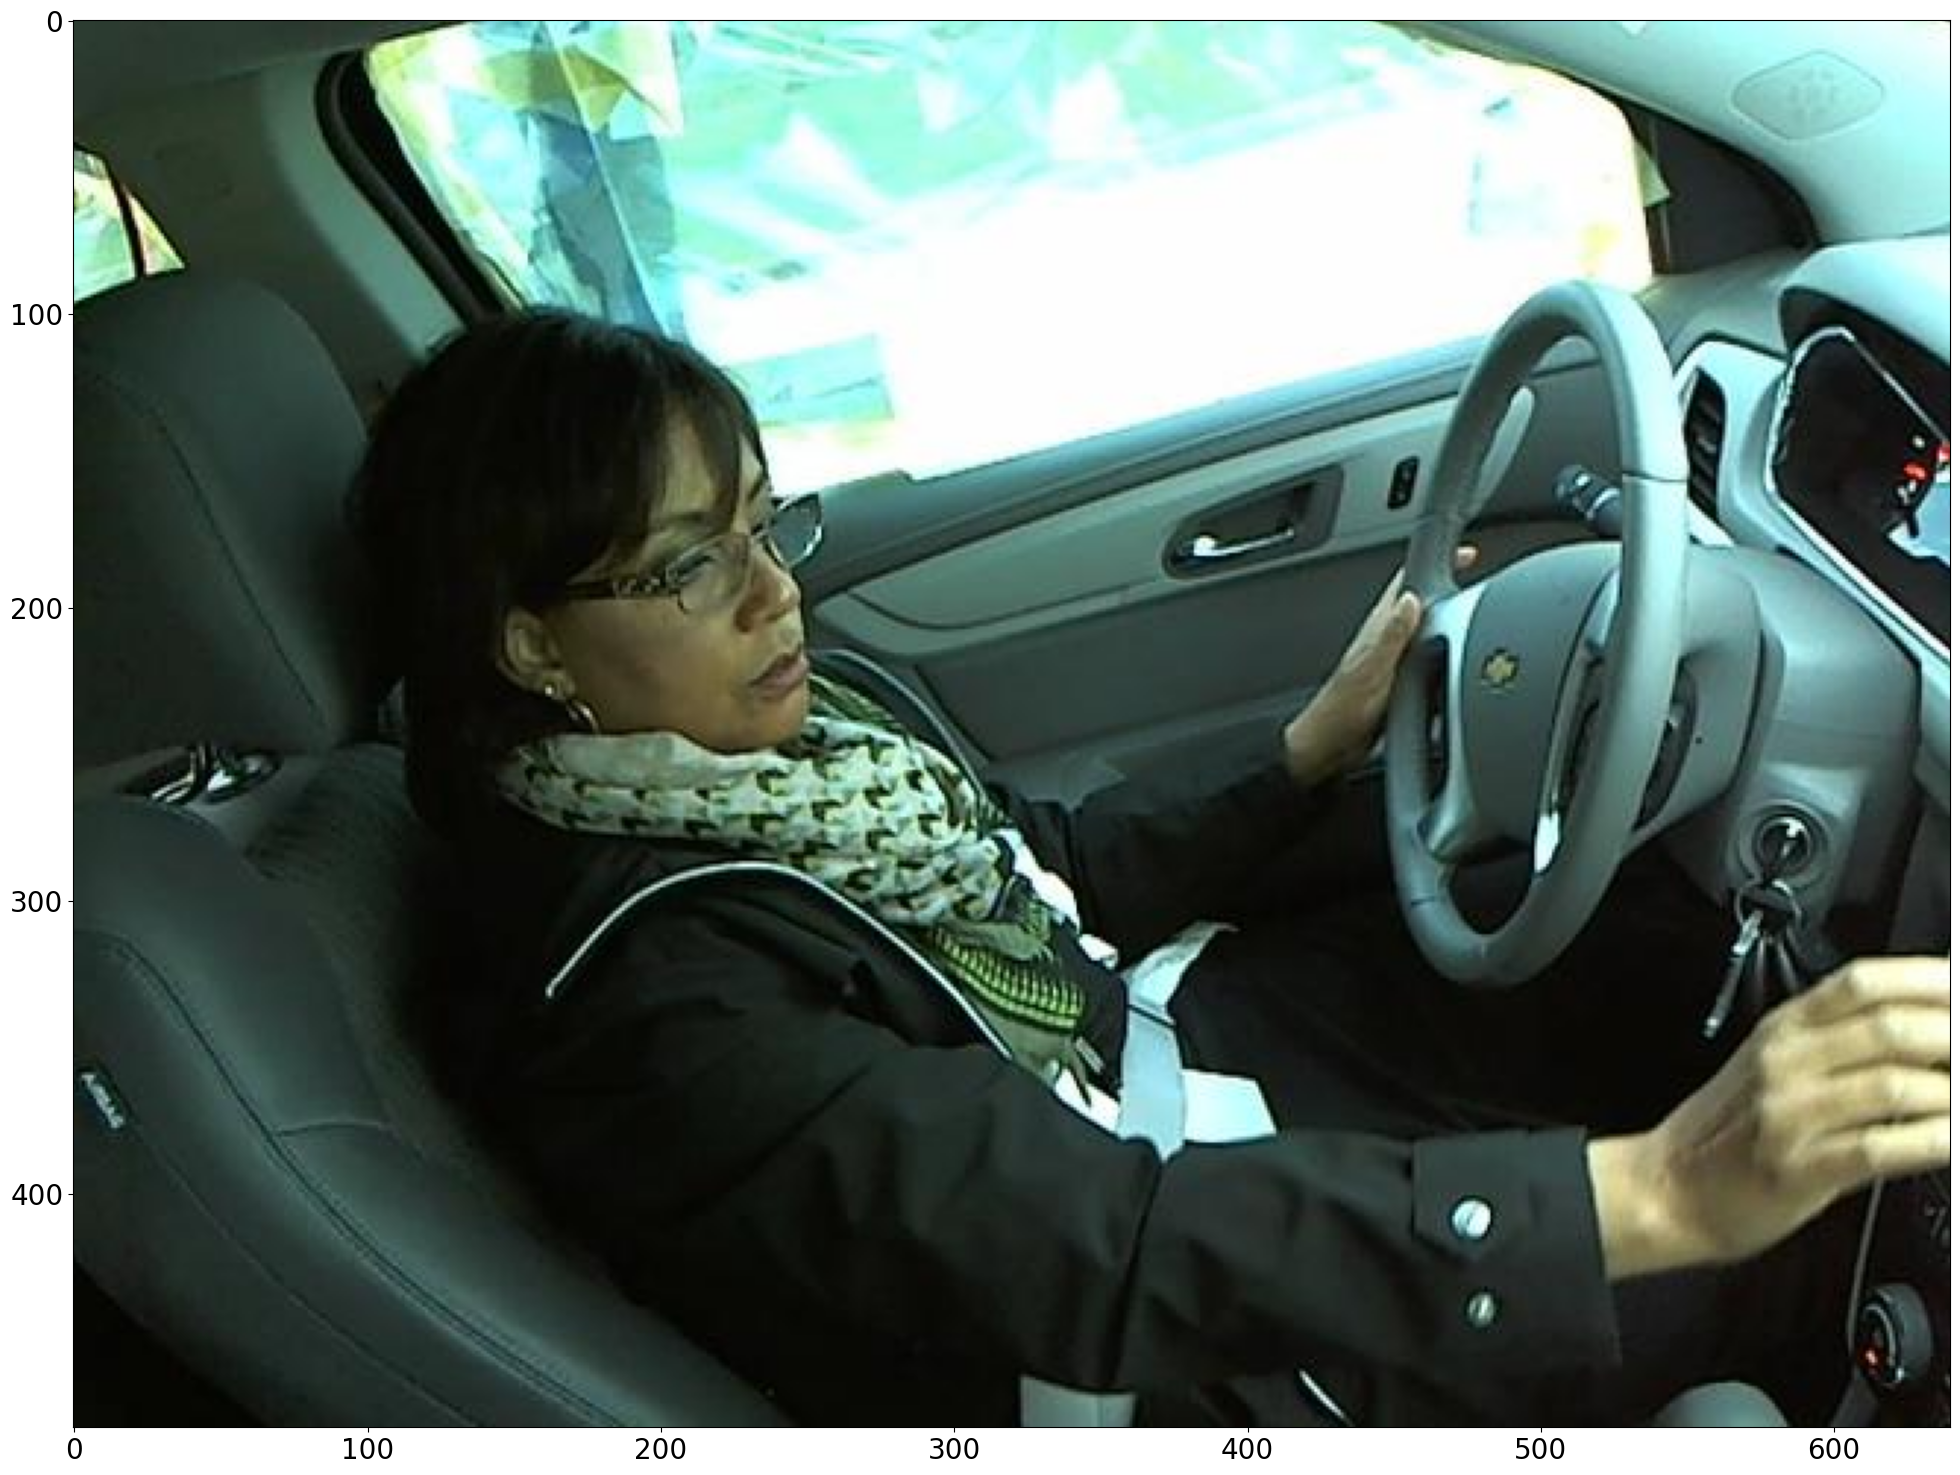

In [44]:
fig = plt.figure(figsize=(20, 18))
test_imgs = os.path.join(abspath_curr, "imgs", "test")
im = Image.open(os.path.join(test_imgs, 'img_1.jpg'))
plt.imshow(im)
plt.tight_layout()
plt.show()

In [45]:
im = Image.open("./imgs/train/c7/img_100702.jpg")
w, h = im.size
print(w, h)

640 480


Size of the image = 640, 480

Total number of training data : 22424


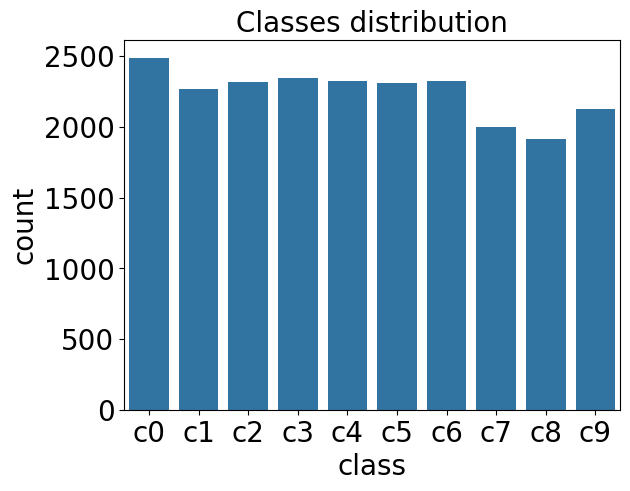

In [46]:

d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(train_imgs,c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
ax = sns.countplot(data=df,x="class")
ax.set(title="Classes distribution")
print("Total number of training data :",len(df))

In [47]:
import plotly.express as px

drivers = pd.DataFrame((driver_imgs_list['subject'].value_counts()).reset_index())
drivers.columns = ['driver_id', 'Counts']
px.histogram(drivers, x="driver_id", y='Counts', color="driver_id", title="Number of images by drivers")

In [48]:
## Randomly shuffling the images
random.shuffle(train_image)

In [49]:
## getting list of driver names

D = []
for features,labels,drivers in train_image:
    D.append(drivers)

## Deduplicating drivers

deduped = []

for i in D:
    if i not in deduped:
        deduped.append(i)
    

## selecting random drivers for the validation set
driv_selected = []
import random
driv_nums = random.sample(range(len(deduped)), 4)
for i in driv_nums:
    driv_selected.append(deduped[i])

### Splitting training and validation

Splitting training and validation set according to the drivers

In [50]:
## Splitting the train and test

X_train= []
y_train = []
X_val = []
y_val = []
D_train = []
D_val = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_val.append(features)
        y_val.append(labels)
        D_val.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_val))
print (len(y_train),len(y_val))

18244 4180
18244 4180


### Encoding target and resize image

In [51]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_val= np.array(X_val).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


print (X_train.shape)

(18244, 224, 224, 3)


The images are resized to a square images i.e. 224 x 224 pixels.

Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.

## Training

### Creating the directory for the model

In [52]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/model/')
if not os.path.exists(directory):
    os.makedirs(directory)

### Building the architecture of the model

In [53]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(224,224,3),padding = 'same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(BatchNormalization())

model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(BatchNormalization())


model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(BatchNormalization())


model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,052,170 (49.79 MB)

 Trainable params: 13,051,338 (49.79 MB)

 Non-trainable params: 832 (3.25 KB)

### Compiling the model

In [54]:
# Compile the model
sgd = SGD(learning_rate=0.001)
model.compile(optimizer= sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [55]:
# Train, evaluate and save the best model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
571/571 ━━━━━━━━━━━━━━━━━━━━ 1475s 3s/step - accuracy: 0.7226 - loss: 0.9126 - val_accuracy: 0.2967 - val_loss: 2.1600
Epoch 2/5
571/571 ━━━━━━━━━━━━━━━━━━━━ 1339s 2s/step - accuracy: 0.9900 - loss: 0.0559 - val_accuracy: 0.3349 - val_loss: 2.0694
Epoch 3/5
571/571 ━━━━━━━━━━━━━━━━━━━━ 1362s 2s/step - accuracy: 0.9971 - loss: 0.0236 - val_accuracy: 0.3536 - val_loss: 2.0372
Epoch 4/5
571/571 ━━━━━━━━━━━━━━━━━━━━ 4526s 8s/step - accuracy: 0.9988 - loss: 0.0143 - val_accuracy: 0.3648 - val_loss: 2.0378
Epoch 5/5
571/571 ━━━━━━━━━━━━━━━━━━━━ 1425s 2s/step - accuracy: 0.9998 - loss: 0.0096 - val_accuracy: 0.3694 - val_loss: 2.0458


# Model Analysis

### Plotting the learning curve

#### Creating the directory for the figure

In [56]:
# Make directory
import os
directory = os.path.dirname(abspath_curr + '/result/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

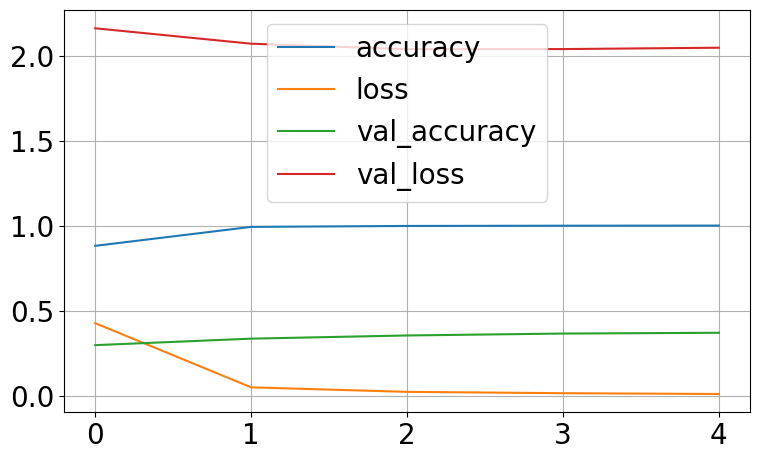

In [57]:

# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/result/figure/learning_curve_CNN_Scratch_withoutleakage.pdf')
plt.show()

In [58]:
y_pred = model.predict(X_val)
y_pred = [np.argmax(ele) for ele in y_pred]
y_pred = np.array(y_pred)

# Calculate the confusion matrix
y_true = [np.argmax(ele) for ele in y_val]
y_true =  np.array(y_true)

conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 415ms/step
Confusion Matrix:
[[130   0   0  82  50  16   1   9  40  95]
 [ 24 138   0  11   0   3   6  30 172  52]
 [  0  18  26   2  15   0  89  39 187  48]
 [  8   0   0 266  74  42   0   0  14  33]
 [  9   1   0  11 119  33   1   7 105 159]
 [ 17   0   0  12  48 155   0   1 183  32]
 [  5   6   0   1   1   0 149   6 179  90]
 [  1   6   1  12   9   0   1 217  70  42]
 [ 11  14  13  16   9   2   5  86 156  53]
 [ 42   1   1  70  50  26   1   3  24 188]]


<Axes: >

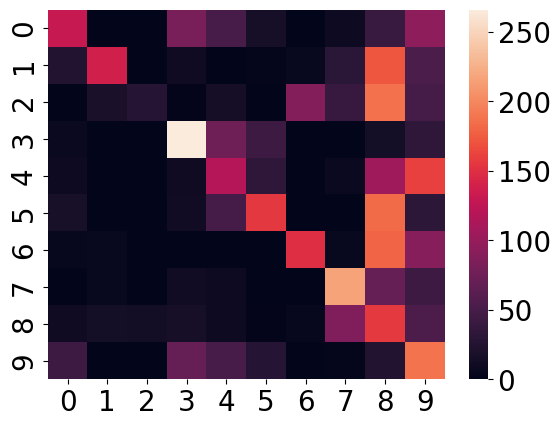

In [59]:
sns.heatmap(conf_matrix)

# End